# Image captioning with visual attention
# Flickr 8K 
## By: Inbasekaran

# Loading all the dependencies

In [1]:
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tqdm import tqdm
from glob import glob
from PIL import Image
import nltk
import string
import warnings
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [2]:
warnings.filterwarnings("ignore")
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Defining the constants 

In [4]:
# image height according the the model architecture
IMG_H = 224
# image width according the the model architecture
IMG_W = 224

In [5]:
# Batch size
BATCH_SIZE = 100
# Buffer size 
BUFFER_SIZE = 1000

# Defining img file paths 

In [6]:
# Dir which contains all the images. 
IMG_FILE_PATH = "C:\\Users\\inba2\\Documents\\DataSet\\8k\\Images\\Images\\"


# Defining txt file paths 

In [7]:
# txt file containg the unprocessed captions
CAP_TEXT_PATH = r"C:\Users\inba2\Documents\DataSet\8k\Flickr_TextData\Flickr8k.token.txt"
# txt file containing the names of the train imgs 
TRAIN_TXT_PATH = r"C:\Users\inba2\Documents\DataSet\8k\Flickr_TextData\Flickr_8k.trainImages.txt"
# txt file containing the names of the test imgs 
TEST_TXT_PATH = r"C:\Users\inba2\Documents\DataSet\8k\Flickr_TextData\Flickr_8k.testImages.txt"
# txt file containing the names of the validation imgs 
VAL_TXT_PATH = r"C:\Users\inba2\Documents\DataSet\8k\Flickr_TextData\Flickr_8k.devImages.txt"

# Text file path
TXT_PATH = r"C:\Users\inba2\Documents\DataSet\8k\Flickr_TextData\Flickr_8k.trainImages.txt"

# Utility Functions to load and clean images


In [8]:
def all_img_name_vector(images_path: str, ext: str = r".jpg") -> list:
    """
    :param ext: extension of the image
    :returns the path of all the images in that dir
    :param images_path: the path of the dir in which the images are present
    """
    # Creating a list of the all the image paths
    images_path_list = glob(images_path + '*.jpg')
    # Printing the number of images in the given directory
    print(f"{len(images_path_list)} images found from {images_path}.")
    return images_path_list


In [9]:
def cnn_model() -> tf.keras.Model:
    """
    returns the cnn model need for feature extraction
    :return:Vgg16 without the last layer.
    """
    # load the model
    model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
    # re-structure the model
    model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # summarize the model
    print(model.summary())
    return model

In [10]:
def load_img(image_path: str, img_h: str = IMG_H, img_w: str = IMG_W) -> (object, str):
    """
    Returns the numpy image and the image path
    :param image_path: the path of the image
    EG: 'C:\\Users\\inba2\\Documents\\DataSet\\8k\\Images\\Images\\1000268201_693b08cb0e.jpg'
    :param img_w: the width of image taken into the cnn
    :param img_h: the height of image taken into the cnn
    :return: image and image_path
    """
    # Read the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    # Resizing the image according the the model architecture
    img = tf.image.resize(img, (img_h, img_w))
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img, image_path

In [11]:
def load_doc(filename: str) -> str:
    """
    to open the file as read only
    :param filename: name of the file
    :return: the entire text as a string
    """
    with open(filename, 'r') as file:
        text = file.read()
    return text

In [12]:
def load_set(text_file_path: str) -> set:
    """
    to load a pre-defined list of photo names
    returns the names of the images form the set_text_file
    :param text_file_path:
    :return:
    """
    # user defined to load the document
    doc = load_doc(text_file_path)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image name without the extension
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [13]:
def img_name_2_path(image_name: str, img_file_path: str = IMG_FILE_PATH, ext: str = r".jpg") -> str:
    """
    Converts the name of the image to image path
    :param image_name: The name of the image
    :param img_file_path: The path where the image is stored
    :param ext:The extension of the image default is .jpg
    :return: The image path
    """
    image_path = img_file_path + str(image_name) + ext
    return image_path

In [14]:
def load_img_dataset(txt_path: str, batch_size=BATCH_SIZE):
    """
    To load the train or test dataset
    :param txt_path: The text file which has the names of the training images
    :param batch_size: The batch size for processing
    :return: image_dataset
    """
    img_name_vector = load_set(txt_path)
    img_path_list = map(img_name_2_path, img_name_vector)
    encode_train = sorted(img_path_list)
    image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
    image_dataset = image_dataset.map(load_img, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)
    return image_dataset

# Features extractraction 

## Loading the train images 

In [15]:
TRAIN_TXT_PATH

'C:\\Users\\inba2\\Documents\\DataSet\\8k\\Flickr_TextData\\Flickr_8k.trainImages.txt'

In [16]:
image_train_dataset = load_img_dataset(TRAIN_TXT_PATH)

In [17]:
image_train_dataset

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>

## Creating our image features extraction model 

In [18]:
image_features_extract_model = cnn_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## Extracting features and saving it in the same dir

In [19]:
if str(input("Do you want to extract the features of the images[y/Y]: ")).casefold() == 'y':
    for img, path in tqdm(image_train_dataset):
        batch_features = image_features_extract_model(img)
        batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
        for bf, p in zip(batch_features, path):
            path_of_feature = p.numpy().decode("utf-8")
            np.save(path_of_feature, bf.numpy())

Do you want to extract the features of the images[y/Y]: n


## Loading the test images 

In [20]:
TEST_TXT_PATH

'C:\\Users\\inba2\\Documents\\DataSet\\8k\\Flickr_TextData\\Flickr_8k.testImages.txt'

In [21]:
image_test_dataset = load_img_dataset(TEST_TXT_PATH)

## Extracting features and saving it in the same dir

In [22]:
if str(input("Do you want to extract the features of the images[y/Y]: ")).casefold() == 'y':
    for img, path in tqdm(image_test_dataset):
        batch_features = image_features_extract_model(img)
        batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
        for bf, p in zip(batch_features, path):
            path_of_feature = p.numpy().decode("utf-8")
            np.save(path_of_feature, bf.numpy())

Do you want to extract the features of the images[y/Y]: n


# Word/Sentence preprocessing

## Helper functions

In [23]:
def clean_cap(caption: str) -> str:
    """
    preprocessing the caption
    :param caption: unprocessed caption
    :return: processed caption
    """
    # Removes Punctuations
    cap = ''.join([ch for ch in caption if ch not in string.punctuation])
    # tokenize
    cap = cap.split()
    # convert to lower case
    cap = [word.casefold() for word in cap]
    # remove hanging 's' and 'a'
    cap = [word for word in cap if len(word) > 1]
    # remove tokens with numbers in them
    cap = [word for word in cap if word.isalpha()]
    # Lemmatizing
    lemmatizer = nltk.WordNetLemmatizer()
    cap = [lemmatizer.lemmatize(word) for word in cap]
    # store as string
    return ' '.join(cap)

In [24]:
def load_cap(caption_txt_path: str) -> dict:
    """
    To read teh text file containing captions and store it in a dict.
    mapping(dict) contains image_name as key and the corresponding captions
    as a list of list of words.
    :param caption_txt_path:
    :return: mapping(dict) contains image_name as key and the
    corresponding captions as a list of captions
    """
    # opening the text file containing the captions
    with open(caption_txt_path, 'r', encoding='utf-8') as caption_txt:
        # each line in the txt file is stored in captions_list(list)
        captions_list = caption_txt.readlines()
    # initializing the dict
    mapping = dict()
    # each line in the text file
    for line in captions_list:
        # split the text by \t
        caption = line.split('\t')
        # the first item of the list
        # -2 ignoring the last two characters and removing the extension
        image_name = caption[0][:-2].split('.')[0]
        # cleaning up the caption(-1 for removing the \n)
        image_caption = clean_cap(caption[-1][:-1])
        # adding start and end of seq
        image_caption = ('startofseq ' + image_caption + ' endofseq')
        # appending the caption with the name as key
        if image_name in mapping:
            mapping[image_name].append(image_caption)
        # if the image_name key is new the creating a key value
        else:
            mapping[image_name] = [image_caption]
    return mapping

In [25]:
def save_captions(mapping: dict, filename: str) -> bool:
    """
    To write the mappings in the disk, one per line.
    written as "key<space>caption"
    :param mapping: dict with image_name as key and the
    corresponding captions as a list of captions
    :param filename: file name to save
    """
    lines = list()
    for key, cap_list in mapping.items():
        for cap in cap_list:
            lines.append(key + ' ' + cap)
    data = '\n'.join(lines)
    with open(filename, 'w') as file:
        file.write(data)
    return True

In [26]:
def load_doc(filename: str) -> str:
    """
    to open the file as read only
    :param filename: name of the file
    :return: the entire text as a string
    """
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

In [27]:
def load_set(text_file_path: str) -> set:
    """
    to load a pre-defined list of photo names
    returns the names of the images form the set_text_file
    :param text_file_path:
    :return:
    """
    # user defined to load the document
    doc = load_doc(text_file_path)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image name without the extension
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [28]:
def load_clean_cap(caption_txt_path: str, dataset: set) -> dict:
    """
    load clean descriptions into memory
    :param caption_txt_path: The path where the clean captions were saved
    :param dataset: the img names of the tining or test data set
    :return: dict of captions mapped with its curr name
    """
    doc = load_doc(caption_txt_path)
    clean_captions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split name and captions
        image_name, image_cap = tokens[0], " ".join(tokens[1:])
        # skip the images which are not in the set.
        if image_name in dataset:
            # creating a list
            if image_name not in clean_captions:
                clean_captions[image_name] = list()
            clean_captions[image_name].append(image_cap)
    return clean_captions


In [29]:
def max_len(clean_captions: dict) -> int:
    """
    Returns the length of the caption with most words
    :param clean_captions: a dictionary of captions 
    :return: length of the longest caption 
    """
    # Converts a dictionary of clean captions and returns a list of captions.
    clean_captions_list = [caption.split() for captions in clean_captions.values()
                           for caption in captions]
    return max(len(caption) for caption in clean_captions_list)

In [30]:
def create_tokenizer(captions_dict: dict, top_k: int = 2000) -> Tokenizer:
    """
    Fit a tokenizer given caption descriptions
    :param captions_dict: (dict) of clean captions
    :param top_k: number of words in vocabulary
    :return: tokenizer object
    """
    clean_captions_list = [caption for captions in captions_dict.values()
                           for caption in captions]
    tokenizer = Tokenizer(num_words=top_k, oov_token="<unk>")
    # Map '<pad>' to '0'
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    tokenizer.fit_on_texts(clean_captions_list)
    return tokenizer

In [31]:
def path_cap_list(img_names_set: set, tokenizer: Tokenizer, captions_dict) -> (list, list):
    """
    a list of image paths and a list of captions for images with corresponding values
    Note: the captions will be tokenized and padded in this function
    :param img_names_set: The set on which the processing is done
    :param tokenizer: tokenizer
    :param captions_dict: clean captions for that set without any tokenization
    """
    tokenized_caps_dict = tokenize_cap(tokenizer, captions_dict)
    image_name_list = sorted(img_names_set)
    capt_list = [cap for name in image_name_list for cap in tokenized_caps_dict[name]]
    img_path_list = [img_name_2_path(name) for name in image_name_list for i in range(len(tokenized_caps_dict[name]))]
    return img_path_list, capt_list

In [32]:
def load_npy(image_path: str, cap: str) -> (str, str):
    """
    :returns image tensor vector with the image path 
    :param image_path: 
    :param cap: 
    """
    img_tensor = np.load(image_path.decode('utf-8') + '.npy')
    return img_tensor, cap

In [33]:
def create_dataset(img_path_list: str, cap_list: str) -> object:
    """
    :param img_path_list: The ordered list of img paths with duplication acc to number of captions  
    :param cap_list: the padded caption list with the curr order 
    :return: dataset 
    """
    dataset = tf.data.Dataset.from_tensor_slices((img_path_list, cap_list))
    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_npy, [item1, item2], [tf.float32, tf.int32]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Shuffle and batch
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [34]:
CAP_TEXT_PATH

'C:\\Users\\inba2\\Documents\\DataSet\\8k\\Flickr_TextData\\Flickr8k.token.txt'

Pre processing is also done while loading the captions 

In [35]:
cap_dict = load_cap(CAP_TEXT_PATH)

Finding the maximum len of the captption 

In [36]:
MAX_CAP_LEN = max_len(cap_dict)
print(MAX_CAP_LEN)

34


In [37]:
def tokenize_cap(tokenizer: Tokenizer, captions_dict: dict, pad_len: int = MAX_CAP_LEN) -> dict:
    """
    Tokenizes the captions and
    :param pad_len: The maximum caption length in the whole dataset
    (should include both train and test dataset)
    :param tokenizer: Tokenizer object
    :param captions_dict: The dict of train/test cap which have to be tokenized
    :return: A dict of tokenized captions
    """
    pad_caps_dict = {img_name: pad_sequences(tokenizer.texts_to_sequences(captions), maxlen=pad_len, padding='post')
                     for img_name, captions in captions_dict.items()}
    return pad_caps_dict

In [38]:
CLEAN_CAP_TEXT_PATH = r'C:\Users\inba2\Documents\DataSet\8k\Flickr_TextData\Flickr8k_clean_cap.txt'

## Saving the clean captions 

In [39]:
save_captions(cap_dict,CLEAN_CAP_TEXT_PATH)

True

# Tokenizing words

## Loading the train img names 

In [40]:
train_img_names = sorted(load_set(TRAIN_TXT_PATH))

Loading the train img captions as a dict 

In [41]:
train_img_cap = load_clean_cap(CLEAN_CAP_TEXT_PATH, train_img_names)

In [42]:
len(train_img_cap)

6000

In [43]:
for x in train_img_cap.values():
    print(x)
    break

['startofseq child in pink dress is climbing up set of stair in an entry way endofseq', 'startofseq girl going into wooden building endofseq', 'startofseq little girl climbing into wooden playhouse endofseq', 'startofseq little girl climbing the stair to her playhouse endofseq', 'startofseq little girl in pink dress going into wooden cabin endofseq']


## Creating a tokenizer for training set 

In [44]:
tokenizer = create_tokenizer(train_img_cap)

In [45]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(VOCAB_SIZE)

6537


In [46]:
tokenizer.word_index

{'<unk>': 1,
 'startofseq': 2,
 'endofseq': 3,
 'in': 4,
 'the': 5,
 'on': 6,
 'dog': 7,
 'is': 8,
 'and': 9,
 'with': 10,
 'man': 11,
 'of': 12,
 'two': 13,
 'boy': 14,
 'girl': 15,
 'woman': 16,
 'white': 17,
 'black': 18,
 'are': 19,
 'to': 20,
 'wearing': 21,
 'at': 22,
 'people': 23,
 'water': 24,
 'brown': 25,
 'red': 26,
 'young': 27,
 'child': 28,
 'an': 29,
 'his': 30,
 'blue': 31,
 'running': 32,
 'through': 33,
 'playing': 34,
 'shirt': 35,
 'while': 36,
 'ball': 37,
 'down': 38,
 'standing': 39,
 'little': 40,
 'grass': 41,
 'snow': 42,
 'person': 43,
 'jumping': 44,
 'over': 45,
 'three': 46,
 'stand': 47,
 'jump': 48,
 'sitting': 49,
 'field': 50,
 'run': 51,
 'front': 52,
 'it': 53,
 'holding': 54,
 'play': 55,
 'small': 56,
 'yellow': 57,
 'green': 58,
 'group': 59,
 'up': 60,
 'by': 61,
 'large': 62,
 'one': 63,
 'walking': 64,
 'her': 65,
 'men': 66,
 'mouth': 67,
 'air': 68,
 'player': 69,
 'into': 70,
 'rock': 71,
 'near': 72,
 'beach': 73,
 'street': 74,
 'another'

# Train dataset 

## Tokenizing the train captions and storing it in lists 

In [47]:
img_name_train, caption_train = path_cap_list(train_img_names, tokenizer, train_img_cap)

In [48]:
img_name_train[:10]

['C:\\Users\\inba2\\Documents\\DataSet\\8k\\Images\\Images\\1000268201_693b08cb0e.jpg',
 'C:\\Users\\inba2\\Documents\\DataSet\\8k\\Images\\Images\\1000268201_693b08cb0e.jpg',
 'C:\\Users\\inba2\\Documents\\DataSet\\8k\\Images\\Images\\1000268201_693b08cb0e.jpg',
 'C:\\Users\\inba2\\Documents\\DataSet\\8k\\Images\\Images\\1000268201_693b08cb0e.jpg',
 'C:\\Users\\inba2\\Documents\\DataSet\\8k\\Images\\Images\\1000268201_693b08cb0e.jpg',
 'C:\\Users\\inba2\\Documents\\DataSet\\8k\\Images\\Images\\1001773457_577c3a7d70.jpg',
 'C:\\Users\\inba2\\Documents\\DataSet\\8k\\Images\\Images\\1001773457_577c3a7d70.jpg',
 'C:\\Users\\inba2\\Documents\\DataSet\\8k\\Images\\Images\\1001773457_577c3a7d70.jpg',
 'C:\\Users\\inba2\\Documents\\DataSet\\8k\\Images\\Images\\1001773457_577c3a7d70.jpg',
 'C:\\Users\\inba2\\Documents\\DataSet\\8k\\Images\\Images\\1001773457_577c3a7d70.jpg']

In [49]:
caption_train[:10]

[array([  2,  28,   4,  90, 142,   8, 121,  60, 367,  12, 358,   4,  29,
          1, 618,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0]),
 array([  2,  15, 316,  70, 197, 110,   3,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0]),
 array([   2,   40,   15,  121,   70,  197, 1840,    3,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]),
 array([   2,   40,   15,  121,    5,  358,   20,   65, 1840,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]),
 array([  2,  40,  15,   4,  90, 142, 316,  70, 197,   1,   3,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

## Creating train dataset 

In [50]:
train_dataset = create_dataset(img_name_train, caption_train)

# Test Dataset 

## Loading the test img names 

In [51]:
test_img_names = sorted(load_set(TEST_TXT_PATH))

## Loading the test img captions as a dict 

In [52]:
test_img_cap = load_clean_cap(CLEAN_CAP_TEXT_PATH, test_img_names)

In [53]:
len(test_img_cap)

1000

## Creating the test dataset 

In [54]:
img_name_test, caption_test = path_cap_list(test_img_names, tokenizer, test_img_cap)

In [55]:
test_dataset = create_dataset(img_name_test, caption_test)

# Defining some constants 

In [56]:
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1 # 6537
num_steps = len(train_img_names) // BATCH_SIZE  # 187
EPOCHS = 20
# Shape from last layer of VGG-16 :(7,7,512)
# So, say there are 49 pixel locations now and each pixel is 512 dimensional
features_shape = 512
attention_features_shape = 49 

# Model 

In [57]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [58]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [59]:
def rnn_type(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
    if tf.test.is_gpu_available():
        return tf.compat.v1.keras.layers.CuDNNLSTM(units, 
                                        return_sequences=True, 
                                        return_state=True, 
                                        recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='sigmoid', 
                                   recurrent_initializer='glorot_uniform')

In [60]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
#     self.gru = rnn_type(self.units)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, MAX_CAP_LEN, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * MAX_CAP_LEN, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * MAX_CAP_LEN, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [61]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [62]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

# Checkpoint

In [63]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [64]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [65]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [66]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['startofseq']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [69]:
# Loading weights 
if str(input("Do you want to load weights ? [y/Y] ")).casefold() == 'y':
    encoder.load_weights(r"C:\Users\inba2\Documents\IEEE\Envision\Image_Captioning\Encoder_train_1_8k.h5")
    decoder.load_weights(r"C:\Users\inba2\Documents\IEEE\Envision\Image_Captioning\Decoder_train_1_8k.h5")

Do you want to load weights ? [y/Y] y


In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Saving Weights 

In [ ]:
if os.path.isfile("Encoder_train_1_8k.h5") is False:
    encoder.save_weights("Encoder_train_1_8k.h5")
    print("Encoder saved")

In [ ]:
if os.path.isfile("Decoder_train_1_8k.h5") is False:
    decoder.save_weights("Decoder_train_1_8k.h5")
    print("Decoder saved")

# Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [70]:
def evaluate(image):
    attention_plot = np.zeros((MAX_CAP_LEN, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_img(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['startofseq']], 0)
    result = []

    for i in range(MAX_CAP_LEN):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == 'endofseq':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [71]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result - 1):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

# Validation 

In [72]:
VAL_TXT_PATH = r"C:\Users\inba2\Documents\DataSet\8k\Flickr_TextData\Flickr_8k.devImages.txt"

In [73]:
val_img_names = sorted(load_set(TEST_TXT_PATH))

In [74]:
val_img_cap = load_clean_cap(CLEAN_CAP_TEXT_PATH, val_img_names)

In [75]:
len(val_img_cap)

1000

In [76]:
image_name = val_img_names[np.random.randint(0, len(val_img_names))]
img_path = img_name_2_path(image_name)
real_captions = val_img_cap[image_name]

Prediction Caption: brown dog is jumping in the grass wearing large field of grass and grass
Real Captions:
1)  brown dog walk on the rock near river 
2)  dog is walking through some gravel beside river 
3)  dog with snub nose smell for somthing on riverbank 
4)  large brown dog is walking along side river 
5)  large tan bulldog walking along the rocky shore of small stream 


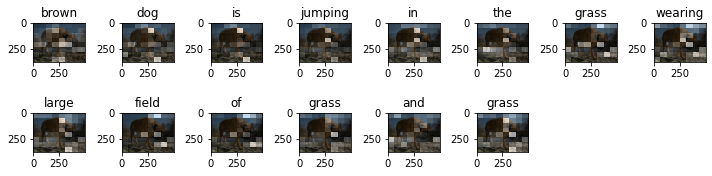

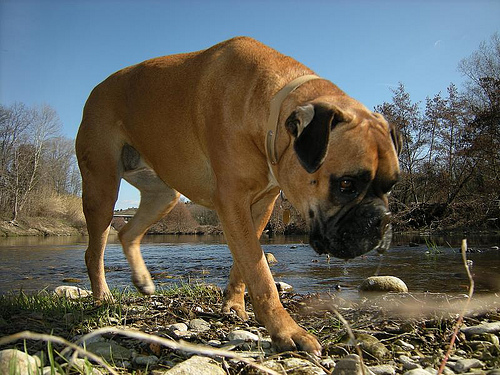

In [77]:
result, attention_plot = evaluate(img_path)
print('Prediction Caption:', ' '.join(result[:-1]))
print('Real Captions:')
for i, cap in enumerate(real_captions):
    print(f"{i+1}) {cap[10:-8]}")
plot_attention(img_path, result, attention_plot)
Image.open(img_path)

# Try it on your own images
For fun, below we've provided a method you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


In [ ]:
img_path = str(input("Enter the image path: "))

In [ ]:
img_path

In [ ]:
result, attention_plot = evaluate(img_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(img_path, result, attention_plot)
# opening the image
Image.open(img_path)

# ------------------------------------ THANK YOU ------------------------------------